In [2]:
# Imports
import cv2
import math
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy import signal
import itertools

figsize = (15, 10)

# Print the full NumPy array
import sys
np.set_printoptions(threshold=sys.maxsize)

In [32]:
# Note: the centers are (x, y), might need to change it to (y, x) depends on the implementation

# Example input for "Digital_all_labels.jpg"

# Input for circles
circles_center = [(52, 19)]
circles_radius = [10]

# Input for rectangles
rectangles_center = [(18, 174), (88, 174)]
rectangles_width = [21, 21]
rectangles_height = [21, 21]

# Input for rhombuses
rhombuses_center = [(54, 96)]
rhombuses_width = [25]
rhombuses_height = [25]

# Input for line arrow
line_arrow_start = [(52, 27), (44, 106)]
line_arrow_end = [(52, 77), (17, 164)]

# Input for dot arrow
dot_arrow_start = [(61, 106)]
dot_arrow_end = [(87, 164)]

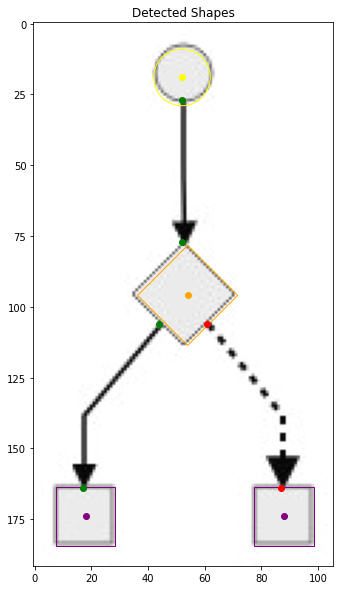

In [36]:
# Showing the example input

# Reading image
path = "Digital_all_labels.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(img, cmap='gray')
ax.set_title("Detected Shapes")


# mark the center of the circles by a yellow point
ax.plot([tpl[0] for tpl in circles_center],[tpl[1] for tpl in circles_center], 'o', color='yellow')
# draw the circumference of the circles in yellow
for center_coordinates, radius in zip(circles_center, circles_radius):
    circ = plt.Circle(center_coordinates, radius, color='yellow', fill=False)
    ax.add_artist(circ)

# mark the center of the rectangles by a purple point
ax.plot([tpl[0] for tpl in rectangles_center],[tpl[1] for tpl in rectangles_center], 'o', color='purple')
# draw the circumference of the rectangles in purple
for (y, x), width, height in zip(rectangles_center, rectangles_width, rectangles_height):
    dx = width/2
    dy = height/2
    rect = plt.Rectangle((y-dy,x-dx), width, height, 0.0, color='purple', fill=False)
    ax.add_artist(rect)

# mark the center of the rhombuses by a orange point
ax.plot([tpl[0] for tpl in rhombuses_center],[tpl[1] for tpl in rhombuses_center], 'o', color='orange')
# draw the circumference of the rhombuses in orange
for (y, x), width, height in zip(rhombuses_center, rhombuses_width, rhombuses_height):
    half_diagonal = norm([width, height])/2
    alpha = math.radians(45) + math.atan(height/width)
    dx = half_diagonal * math.sin(alpha)
    dy = half_diagonal * math.cos(alpha)
    rect = plt.Rectangle((y-dy,x-dx), width, height, 45.0, color='orange', fill=False) # 45 degree anti-clockwise
    ax.add_artist(rect)

# mark the start of the line arrow by a purple point
ax.plot([tpl[0] for tpl in line_arrow_start],[tpl[1] for tpl in line_arrow_start], 'o', color='green')
# mark the end of the line arrow by a purple point
ax.plot([tpl[0] for tpl in line_arrow_end],[tpl[1] for tpl in line_arrow_end], 'o', color='green')
# mark the start of the dot arrow by a red point
ax.plot([tpl[0] for tpl in dot_arrow_start],[tpl[1] for tpl in dot_arrow_start], 'o', color='red')
# mark the end of the dot arrow by a red point
ax.plot([tpl[0] for tpl in dot_arrow_end],[tpl[1] for tpl in dot_arrow_end], 'o', color='red')

In [57]:
# Names for the nodes
prefix_circle = "Circle_"
prefix_rectangle = "Rectangle_"
prefix_rhombus = "Rhombus_"

counter_circle = 0
counter_rectangle = 0
counter_rhombus = 0

def get_name_circle():
    global counter_circle
    result = prefix_circle + str(counter_circle)
    counter_circle += 1
    return result

def get_name_rectangle():
    global counter_rectangle
    result = prefix_rectangle + str(counter_rectangle)
    counter_rectangle += 1
    return result

def get_name_rhombus():
    global counter_rhombus
    result = prefix_rhombus + str(counter_rhombus)
    counter_rhombus += 1
    return result

In [107]:
# Note: If the point is inside the shape, return 0 distance.

def get_distance_from_point_to_circle_circumference(point_center, circle_center, circle_radius):
    x1, y1 = point_center
    x2, y2 = circle_center
    r      = circle_radius

    dist_from_center = norm([x1 - x2, y1 - y2])
    return max(0, dist_from_center - r)

def get_distance_from_point_to_rectangle_circumference(point_center, rectangle_center, rectangle_width, rectangle_height):
    x1, y1 = point_center
    x2, y2 = rectangle_center
    w      = rectangle_width
    h      = rectangle_height

    half_w   = w/2
    half_h   = h/2
    left_x   = x2 - half_w
    right_x  = x2 + half_w
    bottom_y = y2 - half_h
    top_y    = y2 + half_h

    is_in_x_axis = (left_x <= x1) and (x1 <= right_x)
    is_in_y_axis = (bottom_y <= y1) and (y1 <= top_y)

    # Checking if inside the shape
    if is_in_x_axis and is_in_y_axis:
        return 0
    
    # Finding the distance from each edge
    temp1 = y1 - top_y
    temp2 = y1 - bottom_y
    temp3 = x1 - left_x
    temp4 = x1 - right_x

    top = 0 # Top edge
    bottom = 0 # Bottom edge
    if is_in_x_axis:
        top    = abs(temp1)
        bottom = abs(temp2)
    else:
        top    = min(norm([temp3, temp1]), norm([temp4, temp1]))
        bottom = min(norm([temp3, temp2]), norm([temp4, temp2]))
    
    left = 0 # Left edge
    right = 0 # Right edge
    if is_in_y_axis:
        left  = abs(temp3)
        right = abs(temp4)
    else:
        left  = min(norm([temp3, temp1]), norm([temp3, temp2]))
        right = min(norm([temp4, temp1]), norm([temp4, temp2]))
    
    # Returning the min distance
    return min(top, bottom, left, right)

def get_distance_from_point_to_rhombus_circumference(point_center, rhombus_center, rhombus_width, rhombus_height):
    x1, y1 = point_center
    x2, y2 = rhombus_center
    w      = rhombus_width
    h      = rhombus_height

    # Rotating both points 45 degrees countclock-wise
    degree = math.radians(45)
    temp_cos = math.cos(degree)
    temp_sin = math.sin(degree)

    x1_new = (x1 * temp_cos) - (y1 * temp_sin)
    y1_new = (x1 * temp_sin) - (y1 * temp_cos)

    x2_new = (x2 * temp_cos) - (y2 * temp_sin)
    y2_new = (x2 * temp_sin) - (y2 * temp_cos)

    return get_distance_from_point_to_rectangle_circumference((x1_new, y1_new), (x2_new, y2_new), w, h)

def which_shape_this_point_belong_to(point_center):
    circles_distance = [
                        get_distance_from_point_to_circle_circumference(point_center, circle_center, circle_radius)
                        for circle_center, circle_radius in zip(circles_center, circles_radius)
                       ]
    circles_min = np.argmin(circles_distance) if not circles_distance else -1

    rectangles_distance = [
                           get_distance_from_point_to_rectangle_circumference(
                               point_center,
                               rectangle_center, rectangle_width, rectangle_height)
                           for rectangle_center, rectangle_width, rectangle_height
                           in zip(rectangles_center, rectangles_width, rectangles_height)
                          ]
    rectangles_min = np.argmin(rectangles_distance) if not rectangles_distance else -1

    rhombuses_distance = [
                           get_distance_from_point_to_rhombus_circumference(
                               point_center,
                               rhombus_center, rhombus_width, rhombus_height)
                           for rhombus_center, rhombus_width, rhombus_height
                           in zip(rhombuses_center, rhombuses_width, rhombuses_height)
                          ]
    rhombuses_min = np.argmin(rhombuses_distance) if not rhombuses_distance else -1

    

In [123]:
point_center = (52, 27)
circles_distance = [
                    x
                    for x in [1]
                   ]
a = circles_distance if not circles_distance else 1
a

1

In [ ]:
############################################################### TESTS ###############################################################
print(get_distance_from_point_to_circle_circumference(
    line_arrow_start[0],
    circles_center[0],
    circles_radius[0])) # 0
print(get_distance_from_point_to_circle_circumference(
    (52,30),
    circles_center[0],
    circles_radius[0])) # 1

print(get_distance_from_point_to_rectangle_circumference(
    dot_arrow_end[0],
    rectangles_center[1],
    rectangles_width[1],
    rectangles_height[1])) # 0
print(get_distance_from_point_to_rectangle_circumference(
    (87, 154),
    rectangles_center[1],
    rectangles_width[1],
    rectangles_height[1])) # 9.5
print(get_distance_from_point_to_rectangle_circumference(
    (87, 194),
    rectangles_center[1],
    rectangles_width[1],
    rectangles_height[1])) # 9.5
print(get_distance_from_point_to_rectangle_circumference(
    (70, 174),
    rectangles_center[1],
    rectangles_width[1],
    rectangles_height[1])) # 7.5
print(get_distance_from_point_to_rectangle_circumference(
    (110, 174),
    rectangles_center[1],
    rectangles_width[1],
    rectangles_height[1])) # 11.5
print(get_distance_from_point_to_rectangle_circumference(
    rectangles_center[1],
    rectangles_center[1],
    rectangles_width[1],
    rectangles_height[1])) # 0

print(get_distance_from_point_to_rhombus_circumference(
    line_arrow_end[0],
    rhombuses_center[0],
    rhombuses_width[0],
    rhombuses_height[0])) # 0 # not quite sure if it's true, too lazy to check